In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
import joblib
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
pd.set_option('display.max_columns', None)

In [34]:
# Crear carpeta para modelos
os.makedirs('models', exist_ok=True)

In [35]:
# Cargar datos
print("📂 Cargando datos...")
df = pd.read_csv('data/df_merge_gpa_complete.csv')
print(f"Shape original: {df.shape}")

📂 Cargando datos...
Shape original: (362683, 177)


In [36]:
# Crear variable objetivo: 0 si reprobó (RP o PF), 1 si aprobó (AP)
print("\n🎯 Creando variable objetivo...")
df['APROBO'] = df['ESTADO_MAT_TOMADA_MO'].apply(lambda x: 0 if x in ['RP', 'PF'] else 1)
print(f"Distribución de la variable objetivo:")
print(df['APROBO'].value_counts())
print(f"Porcentaje de aprobados: {df['APROBO'].mean()*100:.2f}%")


🎯 Creando variable objetivo...
Distribución de la variable objetivo:
APROBO
1    322289
0     40394
Name: count, dtype: int64
Porcentaje de aprobados: 88.86%


In [37]:
# Seleccionar features relevantes
features_numericas = [
    # 'VEZ_TOMADA_MO', 'DIFICULTAD_MO', 
    'VEZ_x_DIFICULTAD', 
    'NOTA1_MO', # se incluye para la estimacion del primer termino
    # 'NOTA2MO', ''PROMEDIO_MO'', Porque se estimaran de los que estan viendo los cuales no tendran al iniciar
    'PROM_1PARCIAL', # se incluye para la estimacion del primer termino
    # 'PROM_2PARCIAL', # Porque se estimara en base al general
    # 'PROM_CALIFICACIONES', 
    'MAT_APROBADAS', 
    'PROM_CALIF_APROBADAS', 'TERMINOS_REGISTRADOS',
    'PROM_MAT_REPROBADAS1', 'PROM_MAT_REPROBADAS2', 'PROM_MAT_REPROBADAS3',
    'MUY_FACIL', 'FACIL', 'MODERADA', 'DIFICIL', 'MUY_DIFICIL', 
    # 'promedio_general',
    'PORCENTAJEDISCAPACIDAD', "NUMERO_IDIOMAS", 
    'VECESBUSENTRADA', 'VECESBUSSALIDA', 'CANTIDADCUARTOS', 'CANTIDADBANIO', 
    # "GPA", 
    'edad_ingreso',
    # , 'edad'
    # 'CANT_ACTUAL_MAT_TOMADAS', 'GASTOS_RUBRO', 'T_MAT_TOMADAS', 
    'RATIO_APROBADAS', 'TASA_REPROBACION',
    'LOG_CANT_MAT', 'GPA_CUADRADO', 'LOG_GASTOS_RUBRO'
]

features_categoricas = [
    'TIPOCOLEGIO', 'BECACOLEGIO', 'COD_MATERIA_ACAD_MO',
    'TIENEDISCAPACIDAD', 'TIPODISCAPACIDAD', 'ESTADOCIVIL', 'OTROSIDIOMAS', 
    # 'IDIOMAS', 
    'TIEMPOPROMEDIOLLEGARESPOL', 'NIVELINGLES', 
    # 'POSEETARJETACREDITO', 'POSEETARJETADEBITO',
    'NIVELINSTRUCCIONPADRE', 'NIVELINSTRUCCIONMADRE', 'ESTADOCIVILPADRES',
    'FAMILIARDISCAPACIDAD', 'FAMILIARENFERMEDAD', 'TIPOPARROQUIA',
    'VIVEGRUPOFAMILIAR', 'SEXO', "PERDIO_CARRERA", 'termino'
]

# Filtrar features que existen en el dataframe
features_numericas = [f for f in features_numericas if f in df.columns]
features_categoricas = [f for f in features_categoricas if f in df.columns]

print(f"\n📊 Features seleccionadas:")
print(f"  - Numéricas: {len(features_numericas)}")
print(f"  - Categóricas: {len(features_categoricas)}")


📊 Features seleccionadas:
  - Numéricas: 26
  - Categóricas: 19


In [38]:
# Crear copia del dataframe con features seleccionadas
all_features = features_numericas + features_categoricas + ['anio', 'APROBO']
df_model = df[all_features].copy()

In [39]:
# df_model[((df_model["anio"] == 2025) & (df_model["termino"] == "2S"))]
# df_model = df_model.dropna(subset=['PROM_1PARCIAL', 'PROM_2PARCIAL', 'PROM_CALIFICACIONES'])

In [40]:
# Eliminar filas con valores nulos en features numéricas críticas
print(f"\n🧹 Limpiando datos...")
print(f"Registros antes de limpieza: {len(df_model)}")

# REVISAR HAY MUCHOS NULOS
# df_model = df_model.dropna(subset=['PROM_1PARCIAL', 'PROM_2PARCIAL', 'PROM_CALIFICACIONES']) # no porque 2025 2S tambien tiene null
df_model = df_model.dropna(subset=['anio', 'termino'])
print(f"Registros después de limpieza: {len(df_model)}")


🧹 Limpiando datos...
Registros antes de limpieza: 362683
Registros después de limpieza: 362683


In [41]:
# Rellenar valores nulos en features numéricas con la mediana
# no se incluye categorica ni ['anio', 'REPROBO'] ya que son numericas sin nulo
print("1. Numericas")
for col in features_numericas:
    if df_model[col].isnull().sum() > 0:
        print(col)
        df_model[col].fillna(df_model[col].median(), inplace=True)
# tienen que suavizarse los nulos
# PROM_MAT_REPROBADAS1, PROM_MAT_REPROBADAS2, PROM_MAT_REPROBADAS3

# Rellenar valores nulos en features categóricas con 'desconocido'
print("2. Categoricas")
for col in features_categoricas:
    if df_model[col].isnull().sum() > 0:
        print(col)
        df_model[col].fillna('desconocido', inplace=True)

1. Numericas
PROM_1PARCIAL
MAT_APROBADAS
PROM_CALIF_APROBADAS
PROM_MAT_REPROBADAS1
PROM_MAT_REPROBADAS2
PROM_MAT_REPROBADAS3
edad_ingreso
RATIO_APROBADAS
TASA_REPROBACION
2. Categoricas
NIVELINGLES


In [42]:
# Aplicar Label Encoding a variables categóricas
print(f"\n🔄 Aplicando Label Encoding...")
label_encoders = {}

for col in features_categoricas:
    le = LabelEncoder()
    df_model[col + '_encoded'] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le
    print(f"  ✓ {col}: {len(le.classes_)} categorías únicas")

# Guardar label encoders
joblib.dump(label_encoders, 'models/label_encoders.pkl')
print(f"\n💾 Label encoders guardados en 'models/label_encoders.pkl'")

# Preparar features finales (numéricas + categóricas encoded)
features_encoded = [col + '_encoded' for col in features_categoricas]
X_columns = features_numericas + features_encoded


🔄 Aplicando Label Encoding...
  ✓ TIPOCOLEGIO: 8 categorías únicas
  ✓ BECACOLEGIO: 28 categorías únicas
  ✓ COD_MATERIA_ACAD_MO: 689 categorías únicas
  ✓ TIENEDISCAPACIDAD: 2 categorías únicas
  ✓ TIPODISCAPACIDAD: 7 categorías únicas
  ✓ ESTADOCIVIL: 5 categorías únicas
  ✓ OTROSIDIOMAS: 2 categorías únicas
  ✓ TIEMPOPROMEDIOLLEGARESPOL: 6 categorías únicas
  ✓ NIVELINGLES: 5 categorías únicas
  ✓ NIVELINSTRUCCIONPADRE: 13 categorías únicas
  ✓ NIVELINSTRUCCIONMADRE: 13 categorías únicas
  ✓ ESTADOCIVILPADRES: 7 categorías únicas
  ✓ FAMILIARDISCAPACIDAD: 722 categorías únicas
  ✓ FAMILIARENFERMEDAD: 414 categorías únicas
  ✓ TIPOPARROQUIA: 2 categorías únicas
  ✓ VIVEGRUPOFAMILIAR: 2 categorías únicas
  ✓ SEXO: 2 categorías únicas
  ✓ PERDIO_CARRERA: 2 categorías únicas
  ✓ termino: 2 categorías únicas

💾 Label encoders guardados en 'models/label_encoders.pkl'


In [43]:
df_model.head()

,VEZ_x_DIFICULTAD,NOTA1_MO,PROM_1PARCIAL,MAT_APROBADAS,PROM_CALIF_APROBADAS,TERMINOS_REGISTRADOS,PROM_MAT_REPROBADAS1,PROM_MAT_REPROBADAS2,PROM_MAT_REPROBADAS3,MUY_FACIL,FACIL,MODERADA,DIFICIL,MUY_DIFICIL,PORCENTAJEDISCAPACIDAD,NUMERO_IDIOMAS,VECESBUSENTRADA,VECESBUSSALIDA,CANTIDADCUARTOS,CANTIDADBANIO,edad_ingreso,RATIO_APROBADAS,TASA_REPROBACION,LOG_CANT_MAT,GPA_CUADRADO,LOG_GASTOS_RUBRO,TIPOCOLEGIO,BECACOLEGIO,COD_MATERIA_ACAD_MO,TIENEDISCAPACIDAD,TIPODISCAPACIDAD,ESTADOCIVIL,OTROSIDIOMAS,TIEMPOPROMEDIOLLEGARESPOL,NIVELINGLES,NIVELINSTRUCCIONPADRE,NIVELINSTRUCCIONMADRE,ESTADOCIVILPADRES,FAMILIARDISCAPACIDAD,FAMILIARENFERMEDAD,TIPOPARROQUIA,VIVEGRUPOFAMILIAR,SEXO,PERDIO_CARRERA,termino,anio,APROBO,TIPOCOLEGIO_encoded,BECACOLEGIO_encoded,COD_MATERIA_ACAD_MO_encoded,TIENEDISCAPACIDAD_encoded,TIPODISCAPACIDAD_encoded,ESTADOCIVIL_encoded,OTROSIDIOMAS_encoded,TIEMPOPROMEDIOLLEGARESPOL_encoded,NIVELINGLES_encoded,NIVELINSTRUCCIONPADRE_encoded,NIVELINSTRUCCIONMADRE_encoded,ESTADOCIVILPADRES_encoded,FAMILIARDISCAPACIDAD_encoded,FAMILIARENFERMEDAD_encoded,TIPOPARROQUIA_encoded,VIVEGRUPOFAMILIAR_encoded,SEXO_encoded,PERDIO_CARRERA_encoded,termino_encoded
0,62.41,87,5.9,47.0,7.06,17.0,5.14,4.25,5.35,0,0,2,1,0,0.0,1,1,0,2,1,18.0,-0.138836,0.095185,1.386294,45.1584,5.472271,particular,excelencia académica,ACUG1035,n,no definida,casado,si,61 a 90 minutos,desconocido,superior universitaria completa,superior no universitaria (tecnología o técnic...,casados,no,no,urbana,no,masculino,n,1S,2020,1,7,3,0,0,4,0,1,3,2,11,9,0,297,173,1,0,1,0,0
1,62.41,85,6.1,51.0,7.94,14.0,4.16,5.20,5.15,0,0,2,1,0,0.0,0,3,2,3,2,18.0,-0.162519,0.069333,1.386294,51.5524,4.510860,fiscal,ninguna,ACUG1035,n,ninguna,soltero,no,31 a 60 minutos,desconocido,secundaria completa,secundaria incompleta,casados,no,no,urbana,no,femenino,s,1S,2020,1,1,16,0,0,3,2,0,2,2,6,7,0,297,173,1,0,0,1,0
2,62.41,86,5.6,50.0,7.45,13.0,4.27,4.30,4.80,0,1,1,0,1,0.0,1,2,2,2,2,19.0,-0.182322,0.071167,1.386294,45.4276,5.017280,fiscal,ninguna,ACUG1035,n,ninguna,soltero,si,91 a 120 minutos,desconocido,desconocido,desconocido,viudo/a,no,no,rural,no,masculino,s,1S,2020,1,1,16,0,0,3,2,1,4,2,0,0,6,297,173,0,0,1,1,0
3,62.41,83,6.5,47.0,7.93,11.0,3.01,4.93,4.78,0,0,2,2,0,0.0,1,3,3,3,2,18.0,-0.061875,0.060200,1.609438,54.6121,5.446737,particular,ninguna,ACUG1035,n,ninguna,soltero,si,31 a 60 minutos,desconocido,desconocido,secundaria completa,viudo/a,no,no,urbana,no,masculino,n,1S,2020,1,7,16,0,0,3,2,1,2,2,0,6,6,297,173,1,0,1,0,0
4,62.41,95,7.2,39.0,8.02,8.0,4.66,4.93,4.78,0,1,1,1,0,0.0,1,0,0,5,5,18.0,-0.025318,0.166296,1.386294,62.8849,5.602119,particular,ninguna,ACUG1035,n,ninguna,soltero,si,16 a 30 minutos,desconocido,superior universitaria completa,superior universitaria completa,casados,no,no,urbana,no,masculino,n,1S,2020,1,7,16,0,0,3,2,1,1,2,11,11,0,297,173,1,0,1,0,0


#### Separación de datos

In [44]:
anio_objetivo = 2025
termino_objetivo = "2S"

In [45]:
# 1. Datos de inferencia futura: 2025-2S (NO SE USAN EN ENTRENAMIENTO)
mask_inferencia = (df_model['anio'] == anio_objetivo) & (df_model['termino'] == termino_objetivo)
df_inferencia = df_model[mask_inferencia].copy()
df_rest = df_model[~mask_inferencia].copy()

print(f"\n🔮 DATOS PARA INFERENCIA FUTURA (2025-2S):")
print(f"  - Total registros: {len(df_inferencia)}")
if len(df_inferencia) > 0:
    print(f"  - Distribución: {df_inferencia['APROBO'].value_counts().to_dict()}")
    # Guardar datos de inferencia
    df_inferencia.to_csv(f'models/datos_inferencia_{anio_objetivo}_{termino_objetivo}.csv', index=False)
    print(f"  💾 Guardados en 'models/datos_inferencia_{anio_objetivo}_{termino_objetivo}.csv'")
    # Guardar los demas datos para entrenamiento tanto train, validacion como test
    df_rest.to_csv(f'models/datos_entrenamiento_sin_{anio_objetivo}_{termino_objetivo}.csv', index=False)
    print(f"  💾 Guardados en 'models/datos_entrenamiento_sin_{anio_objetivo}_{termino_objetivo}.csv'")
else:
    print(f"  ⚠️ No hay datos disponibles para 2025-2S")


🔮 DATOS PARA INFERENCIA FUTURA (2025-2S):
  - Total registros: 30324
  - Distribución: {1: 30324}
  💾 Guardados en 'models/datos_inferencia_2025_2S.csv'
  💾 Guardados en 'models/datos_entrenamiento_sin_2025_2S.csv'


In [46]:
anio_test = 2025
termino_test = "1S"

In [47]:
# 2. Datos de test: 2025-1S
mask_test = (df_rest['anio'] == anio_test) & (df_rest['termino'] == termino_test)
df_test = df_rest[mask_test].copy()
df_rest_2 = df_rest[~mask_test].copy()

print(f"\n🧪 DATOS DE TEST (2025-1S):")
print(f"  - Total registros: {len(df_test)}")
if len(df_test) > 0:
    print(f"  - Distribución: {df_test['APROBO'].value_counts().to_dict()}")
    X_test = df_test[X_columns]
    y_test = df_test['APROBO']
else:
    print(f"  ⚠️ No hay datos disponibles para 2025-1S")
    X_test, y_test = None, None


🧪 DATOS DE TEST (2025-1S):
  - Total registros: 28650
  - Distribución: {1: 25420, 0: 3230}


In [48]:
# 3. Datos de entrenamiento y validación: 2020-2024 (el resto de semestres)
df_train_val = df_rest_2.copy()
print(f"\n📚 DATOS DE TRAIN + VAL (2020-2024, todos los semestres):")
print(f"  - Total registros: {len(df_train_val)}")
print(f"  - Distribución por año:")
for year in sorted(df_train_val['anio'].unique()):
    count = len(df_train_val[df_train_val['anio'] == year])
    print(f"    • {year}: {count} registros")


📚 DATOS DE TRAIN + VAL (2020-2024, todos los semestres):
  - Total registros: 303709
  - Distribución por año:
    • 2020: 85321 registros
    • 2021: 56178 registros
    • 2022: 54734 registros
    • 2023: 53599 registros
    • 2024: 53877 registros


In [49]:
# Split train/val (80/20) 
X_train_val = df_train_val[X_columns]
y_train_val = df_train_val['APROBO']

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train_val
)

In [50]:
list_years = sorted(df_train_val["anio"].unique().tolist())
print(f"\n📈 DISTRIBUCIÓN FINAL DE DATOS:")
print(f"  ✓ TRAIN (80% de {list_years[0]}-{list_years[-1]}): {len(X_train)} registros")
print(f"    - Aprobados: {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")
print(f"    - Reprobados: {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"\n  ✓ VAL (20% de {list_years[0]}-{list_years[-1]}): {len(X_val)} registros")
print(f"    - Aprobados: {(y_val == 1).sum()} ({(y_val == 1).sum()/len(y_val)*100:.2f}%)")
print(f"    - Reprobados: {(y_val == 0).sum()} ({(y_val == 0).sum()/len(y_val)*100:.2f}%)")

if X_test is not None:
    print(f"\n  ✓ TEST ({anio_test}-{termino_test}): {len(X_test)} registros")
    print(f"    - Aprobados: {(y_test == 1).sum()} ({(y_test == 1).sum()/len(y_test)*100:.2f}%)")
    print(f"    - Reprobados: {(y_test == 0).sum()} ({(y_test == 0).sum()/len(y_test)*100:.2f}%)")

if len(df_inferencia) > 0:
    print(f"\n  🔮 INFERENCIA ({anio_objetivo}-{termino_objetivo}): {len(df_inferencia)} registros")
    print(f"    - (Datos guardados para inferencia futura)")

# Guardar información de features
feature_info = {
    'features_numericas': features_numericas,
    'features_categoricas': features_categoricas,
    'X_columns': X_columns,
    'target': 'APROBO'
}
joblib.dump(feature_info, 'models/feature_info.pkl')
print(f"\n💾 Información de features guardada en 'models/feature_info.pkl'")


📈 DISTRIBUCIÓN FINAL DE DATOS:
  ✓ TRAIN (80% de 2020-2024): 242967 registros
    - Aprobados: 213236 (87.76%)
    - Reprobados: 29731 (12.24%)

  ✓ VAL (20% de 2020-2024): 60742 registros
    - Aprobados: 53309 (87.76%)
    - Reprobados: 7433 (12.24%)

  ✓ TEST (2025-1S): 28650 registros
    - Aprobados: 25420 (88.73%)
    - Reprobados: 3230 (11.27%)

  🔮 INFERENCIA (2025-2S): 30324 registros
    - (Datos guardados para inferencia futura)

💾 Información de features guardada en 'models/feature_info.pkl'


#### Entrenamiento

In [51]:
# Función para entrenar y evaluar modelos
def entrenar_evaluar_modelo(nombre, modelo, X_train, y_train, X_val, y_val, X_test=None, y_test=None):
    print(f"\n{'='*80}")
    print(f"🤖 Entrenando {nombre}...")
    print(f"{'='*80}")
    
    # Entrenar
    modelo.fit(X_train, y_train)
    
    # Predicciones en train
    y_train_pred = modelo.predict(X_train)
    y_train_proba = modelo.predict_proba(X_train)[:, 1] if hasattr(modelo, 'predict_proba') else None
    
    # Predicciones en validación
    y_val_pred = modelo.predict(X_val)
    y_val_proba = modelo.predict_proba(X_val)[:, 1] if hasattr(modelo, 'predict_proba') else None
    
    # Métricas Train
    print(f"\n📊 MÉTRICAS EN TRAIN (80% de 2020-2024):")
    print(f"  Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    if y_train_proba is not None:
        print(f"  ROC-AUC: {roc_auc_score(y_train, y_train_proba):.4f}")
    
    # Métricas Validación
    print(f"\n📊 MÉTRICAS EN VALIDACIÓN (20% de 2020-2024):")
    print(f"  Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
    if y_val_proba is not None:
        print(f"  ROC-AUC: {roc_auc_score(y_val, y_val_proba):.4f}")
    print(f"\n  Classification Report:")
    print(classification_report(y_val, y_val_pred, target_names=['Reprobado', 'Aprobado']))
    
    # Métricas Test (2025-1S)
    if X_test is not None and y_test is not None:
        y_test_pred = modelo.predict(X_test)
        y_test_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, 'predict_proba') else None
        
        print(f"\n📊 MÉTRICAS EN TEST (2025-1S):")
        print(f"  Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
        if y_test_proba is not None:
            print(f"  ROC-AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
        print(f"\n  Classification Report:")
        print(classification_report(y_test, y_test_pred, target_names=['Reprobado', 'Aprobado']))
        
        # Matriz de confusión
        cm = confusion_matrix(y_test, y_test_pred)
        print(f"\n  Matriz de Confusión:")
        print(f"    [[TN={cm[0,0]}, FP={cm[0,1]}],")
        print(f"     [FN={cm[1,0]}, TP={cm[1,1]}]]")
    
    return modelo


In [52]:
def evaluar_modelo_completo(modelo, X, y, nombre_conjunto='Conjunto', 
                           mostrar_graficos=True, guardar_graficos=False, 
                           ruta_guardado='models/'):
    """
    Función completa para evaluar un modelo de clasificación binaria.
    
    Parámetros:
    -----------
    modelo : objeto modelo entrenado
        Modelo de sklearn/xgboost con métodos predict y predict_proba
    X : array-like o DataFrame
        Features del conjunto a evaluar
    y : array-like o Series
        Etiquetas reales del conjunto
    nombre_conjunto : str, default='Conjunto'
        Nombre descriptivo del conjunto (ej: 'Validación', 'Test', etc.)
    mostrar_graficos : bool, default=True
        Si True, muestra gráficos de matriz de confusión y curva ROC
    guardar_graficos : bool, default=False
        Si True, guarda los gráficos en la ruta especificada
    ruta_guardado : str, default='models/'
        Ruta donde guardar los gráficos
    
    Retorna:
    --------
    dict : Diccionario con todas las métricas y predicciones
        {
            'predicciones': array de predicciones,
            'probabilidades': array de probabilidades,
            'matriz_confusion': matriz de confusión,
            'accuracy': exactitud,
            'precision': precisión,
            'recall': sensibilidad,
            'f1_score': f1-score,
            'roc_auc': área bajo la curva ROC,
            'classification_report': reporte de clasificación
        }
    """
    
    print(f"\n{'='*80}")
    print(f"📊 EVALUACIÓN DEL MODELO EN {nombre_conjunto.upper()}")
    print(f"{'='*80}")
    
    # Realizar predicciones
    y_pred = modelo.predict(X)
    
    # Obtener probabilidades si el modelo lo soporta
    if hasattr(modelo, 'predict_proba'):
        y_proba = modelo.predict_proba(X)[:, 1]
    else:
        y_proba = None
        print("⚠️ El modelo no soporta predict_proba, algunas métricas no estarán disponibles")
    
    # Calcular matriz de confusión
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calcular métricas
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, zero_division=0)
    recall = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)
    
    # ROC-AUC solo si tenemos probabilidades
    roc_auc = roc_auc_score(y, y_proba) if y_proba is not None else None
    
    # Imprimir resultados
    print(f"\n📈 MÉTRICAS GENERALES:")
    print(f"  • Accuracy (Exactitud):     {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  • Precision (Precisión):    {precision:.4f} ({precision*100:.2f}%)")
    print(f"  • Recall (Sensibilidad):    {recall:.4f} ({recall*100:.2f}%)")
    print(f"  • F1-Score:                 {f1:.4f}")
    if roc_auc is not None:
        print(f"  • ROC-AUC:                  {roc_auc:.4f}")
    
    print(f"\n📊 MATRIZ DE CONFUSIÓN:")
    print(f"  ┌─────────────────────────────────────┐")
    print(f"  │           Predicción                │")
    print(f"  │         Reprobará  │  Aprobará      │")
    print(f"  ├─────────────────────────────────────┤")
    print(f"  │ Real    │         │                 │")
    print(f"  │ Reprobó │  {tn:6d}   │   {fp:6d}        │  TN / FP")
    print(f"  │ Aprobó  │  {fn:6d}   │   {tp:6d}        │  FN / TP")
    print(f"  └─────────────────────────────────────┘")
    
    print(f"\n📋 INTERPRETACIÓN:")
    print(f"  • Verdaderos Negativos (TN): {tn:,} - Correctamente predichos como REPROBARÁ")
    print(f"  • Falsos Positivos (FP):     {fp:,} - Incorrectamente predichos como APROBARÁ")
    print(f"  • Falsos Negativos (FN):     {fn:,} - Incorrectamente predichos como REPROBARÁ")
    print(f"  • Verdaderos Positivos (TP): {tp:,} - Correctamente predichos como APROBARÁ")
    
    # Métricas adicionales
    total = len(y)
    tasa_aprobados_real = (y == 1).sum() / total
    tasa_reprobados_real = (y == 0).sum() / total
    tasa_aprobados_pred = (y_pred == 1).sum() / total
    tasa_reprobados_pred = (y_pred == 0).sum() / total
    
    print(f"\n📊 DISTRIBUCIÓN:")
    print(f"  Real:")
    print(f"    - Aprobados:  {(y == 1).sum():,} ({tasa_aprobados_real*100:.2f}%)")
    print(f"    - Reprobados: {(y == 0).sum():,} ({tasa_reprobados_real*100:.2f}%)")
    print(f"  Predicho:")
    print(f"    - Aprobados:  {(y_pred == 1).sum():,} ({tasa_aprobados_pred*100:.2f}%)")
    print(f"    - Reprobados: {(y_pred == 0).sum():,} ({tasa_reprobados_pred*100:.2f}%)")
    
    # Classification Report
    print(f"\n📋 CLASSIFICATION REPORT:")
    print(classification_report(y, y_pred, target_names=['Reprobado', 'Aprobado'], digits=4))
    
    # Análisis de probabilidades si están disponibles
    if y_proba is not None:
        print(f"\n📊 ANÁLISIS DE PROBABILIDADES:")
        print(f"  • Probabilidad promedio de reprobar: {y_proba.mean():.4f}")
        print(f"  • Probabilidad mínima: {y_proba.min():.4f}")
        print(f"  • Probabilidad máxima: {y_proba.max():.4f}")
        print(f"  • Desviación estándar: {y_proba.std():.4f}")
        
        # Estudiantes por nivel de riesgo
        alto_riesgo = (y_proba > 0.7).sum()
        riesgo_moderado = ((y_proba > 0.5) & (y_proba <= 0.7)).sum()
        riesgo_bajo = ((y_proba > 0.3) & (y_proba <= 0.5)).sum()
        sin_riesgo = (y_proba <= 0.3).sum()
        
        print(f"\n⚠️ NIVELES DE RIESGO:")
        print(f"  • Alto riesgo (prob > 0.7):        {alto_riesgo:,} ({alto_riesgo/total*100:.2f}%)")
        print(f"  • Riesgo moderado (0.5 < p ≤ 0.7): {riesgo_moderado:,} ({riesgo_moderado/total*100:.2f}%)")
        print(f"  • Riesgo bajo (0.3 < p ≤ 0.5):     {riesgo_bajo:,} ({riesgo_bajo/total*100:.2f}%)")
        print(f"  • Sin riesgo (prob ≤ 0.3):         {sin_riesgo:,} ({sin_riesgo/total*100:.2f}%)")
    
    # Crear gráficos
    if mostrar_graficos or guardar_graficos:
        fig, axes = plt.subplots(1, 2 if y_proba is not None else 1, figsize=(15, 5))
        
        if y_proba is not None:
            ax1, ax2 = axes
        else:
            ax1 = axes
        
        # Gráfico 1: Matriz de Confusión
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Reprobará', 'Aprobará'],
                    yticklabels=['Reprobó', 'Aprobó'],
                    ax=ax1, cbar_kws={'label': 'Cantidad'})
        ax1.set_title(f'Matriz de Confusión - {nombre_conjunto}', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Valor Real', fontsize=12)
        ax1.set_xlabel('Predicción', fontsize=12)
        
        # Agregar porcentajes
        for i in range(2):
            for j in range(2):
                percentage = cm[i, j] / cm.sum() * 100
                ax1.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                        ha='center', va='center', fontsize=10, color='gray')
        
        # Gráfico 2: Curva ROC (si hay probabilidades)
        if y_proba is not None:
            fpr, tpr, thresholds = roc_curve(y, y_proba)
            ax2.plot(fpr, tpr, color='darkorange', lw=2, 
                    label=f'ROC curve (AUC = {roc_auc:.4f})')
            ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
            ax2.set_xlim([0.0, 1.0])
            ax2.set_ylim([0.0, 1.05])
            ax2.set_xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
            ax2.set_ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
            ax2.set_title(f'Curva ROC - {nombre_conjunto}', fontsize=14, fontweight='bold')
            ax2.legend(loc="lower right")
            ax2.grid(alpha=0.3)
        
        plt.tight_layout()
        
        if guardar_graficos:
            import os
            os.makedirs(ruta_guardado, exist_ok=True)
            nombre_archivo = f"{ruta_guardado}evaluacion_{nombre_conjunto.lower().replace(' ', '_')}.png"
            plt.savefig(nombre_archivo, dpi=300, bbox_inches='tight')
            print(f"\n💾 Gráficos guardados en '{nombre_archivo}'")
        
        if mostrar_graficos:
            plt.show()
        else:
            plt.close()
    
    # Preparar diccionario de resultados
    resultados = {
        'predicciones': y_pred,
        'probabilidades': y_proba,
        'matriz_confusion': cm,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'classification_report': classification_report(y, y_pred, 
                                                       target_names=['Reprobado', 'Aprobado'],
                                                       output_dict=True)
    }
    
    print(f"\n{'='*80}")
    print(f"✅ EVALUACIÓN COMPLETADA")
    print(f"{'='*80}\n")
    
    return resultados

#### RandomForestClassifier

In [53]:
# 1. Random Forest
print(f"\n{'#'*80}")
print(f"# MODELO 1: RANDOM FOREST")
print(f"{'#'*80}")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf_model = entrenar_evaluar_modelo('Random Forest', rf_model, X_train, y_train, X_val, y_val, X_test, y_test)
joblib.dump(rf_model, 'models/random_forest_model.pkl')
print(f"\n💾 Modelo guardado en 'models/random_forest_model.pkl'")


################################################################################
# MODELO 1: RANDOM FOREST
################################################################################

🤖 Entrenando Random Forest...

📊 MÉTRICAS EN TRAIN (80% de 2020-2024):
  Accuracy: 0.9106
  ROC-AUC: 0.9777

📊 MÉTRICAS EN VALIDACIÓN (20% de 2020-2024):
  Accuracy: 0.8924
  ROC-AUC: 0.9504

  Classification Report:
              precision    recall  f1-score   support

   Reprobado       0.54      0.85      0.66      7433
    Aprobado       0.98      0.90      0.94     53309

    accuracy                           0.89     60742
   macro avg       0.76      0.87      0.80     60742
weighted avg       0.92      0.89      0.90     60742


📊 MÉTRICAS EN TEST (2025-1S):
  Accuracy: 0.8753
  ROC-AUC: 0.9453

  Classification Report:
              precision    recall  f1-score   support

   Reprobado       0.47      0.89      0.62      3230
    Aprobado       0.98      0.87      0.93     25420

    accu


📊 EVALUACIÓN DEL MODELO EN VALIDACIÓN

📈 MÉTRICAS GENERALES:
  • Accuracy (Exactitud):     0.8753 (87.53%)
  • Precision (Precisión):    0.9837 (98.37%)
  • Recall (Sensibilidad):    0.8739 (87.39%)
  • F1-Score:                 0.9256
  • ROC-AUC:                  0.9453

📊 MATRIZ DE CONFUSIÓN:
  ┌─────────────────────────────────────┐
  │           Predicción                │
  │         Reprobará  │  Aprobará      │
  ├─────────────────────────────────────┤
  │ Real    │         │                 │
  │ Reprobó │    2863   │      367        │  TN / FP
  │ Aprobó  │    3205   │    22215        │  FN / TP
  └─────────────────────────────────────┘

📋 INTERPRETACIÓN:
  • Verdaderos Negativos (TN): 2,863 - Correctamente predichos como REPROBARÁ
  • Falsos Positivos (FP):     367 - Incorrectamente predichos como APROBARÁ
  • Falsos Negativos (FN):     3,205 - Incorrectamente predichos como REPROBARÁ
  • Verdaderos Positivos (TP): 22,215 - Correctamente predichos como APROBARÁ

📊 DISTRIBUC

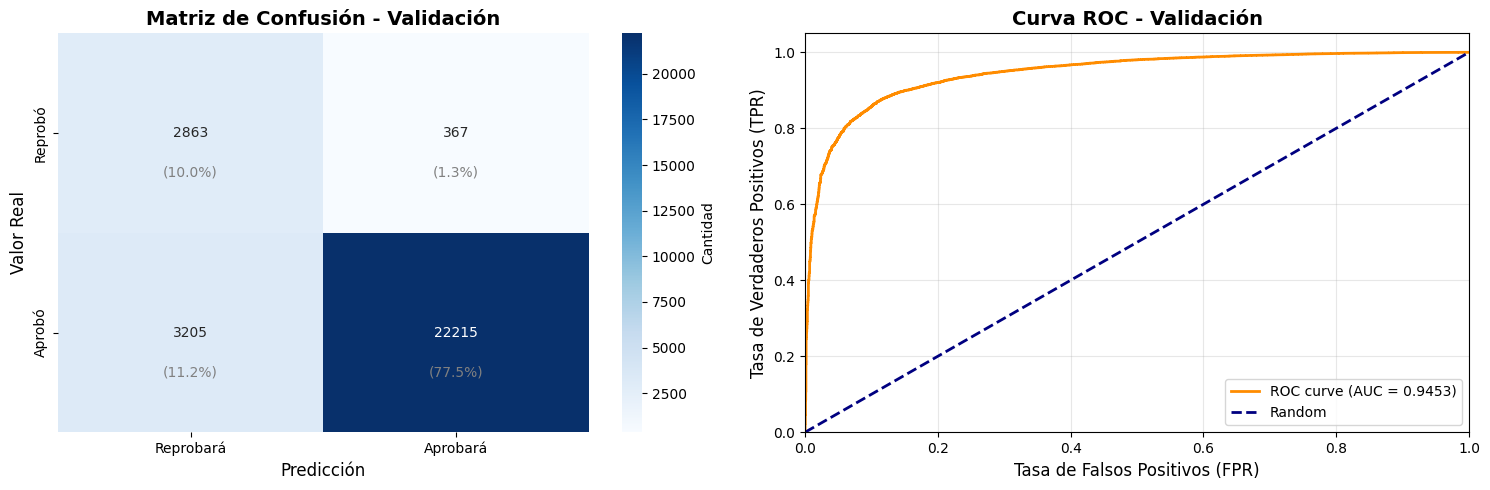


✅ EVALUACIÓN COMPLETADA



In [54]:
resultados_val = evaluar_modelo_completo(
    modelo=rf_model,
    X=X_test,
    y=y_test,
    nombre_conjunto='Validación',
    mostrar_graficos=True,
    guardar_graficos=True,
    ruta_guardado='models/rf_model_'
)

#### SVC

In [55]:
# # 2. SVM
# print(f"\n{'#'*80}")
# print(f"# MODELO 2: SVM")
# print(f"{'#'*80}")
# svm_model = SVC(
#     kernel='rbf',
#     C=1.0,
#     gamma='scale',
#     probability=True,
#     random_state=42,
#     class_weight='balanced'
# )
# svm_model = entrenar_evaluar_modelo('SVM', svm_model, X_train, y_train, X_val, y_val, X_test, y_test)
# joblib.dump(svm_model, 'models/svm_model.pkl')
# print(f"\n💾 Modelo guardado en 'models/svm_model.pkl'")

#### LogisticRegression

In [56]:
# 3. Regresión Logística
print(f"\n{'#'*80}")
print(f"# MODELO 3: REGRESIÓN LOGÍSTICA")
print(f"{'#'*80}")
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    solver='lbfgs'
)
lr_model = entrenar_evaluar_modelo('Regresión Logística', lr_model, X_train, y_train, X_val, y_val, X_test, y_test)
joblib.dump(lr_model, 'models/logistic_regression_model.pkl')
print(f"\n💾 Modelo guardado en 'models/logistic_regression_model.pkl'")


################################################################################
# MODELO 3: REGRESIÓN LOGÍSTICA
################################################################################

🤖 Entrenando Regresión Logística...

📊 MÉTRICAS EN TRAIN (80% de 2020-2024):
  Accuracy: 0.8686
  ROC-AUC: 0.9445

📊 MÉTRICAS EN VALIDACIÓN (20% de 2020-2024):
  Accuracy: 0.8681
  ROC-AUC: 0.9412

  Classification Report:
              precision    recall  f1-score   support

   Reprobado       0.48      0.87      0.62      7433
    Aprobado       0.98      0.87      0.92     53309

    accuracy                           0.87     60742
   macro avg       0.73      0.87      0.77     60742
weighted avg       0.92      0.87      0.88     60742


📊 MÉTRICAS EN TEST (2025-1S):
  Accuracy: 0.8556
  ROC-AUC: 0.9454

  Classification Report:
              precision    recall  f1-score   support

   Reprobado       0.43      0.90      0.58      3230
    Aprobado       0.99      0.85      0.91     254


📊 EVALUACIÓN DEL MODELO EN VALIDACIÓN

📈 MÉTRICAS GENERALES:
  • Accuracy (Exactitud):     0.8556 (85.56%)
  • Precision (Precisión):    0.9854 (98.54%)
  • Recall (Sensibilidad):    0.8499 (84.99%)
  • F1-Score:                 0.9126
  • ROC-AUC:                  0.9454

📊 MATRIZ DE CONFUSIÓN:
  ┌─────────────────────────────────────┐
  │           Predicción                │
  │         Reprobará  │  Aprobará      │
  ├─────────────────────────────────────┤
  │ Real    │         │                 │
  │ Reprobó │    2909   │      321        │  TN / FP
  │ Aprobó  │    3815   │    21605        │  FN / TP
  └─────────────────────────────────────┘

📋 INTERPRETACIÓN:
  • Verdaderos Negativos (TN): 2,909 - Correctamente predichos como REPROBARÁ
  • Falsos Positivos (FP):     321 - Incorrectamente predichos como APROBARÁ
  • Falsos Negativos (FN):     3,815 - Incorrectamente predichos como REPROBARÁ
  • Verdaderos Positivos (TP): 21,605 - Correctamente predichos como APROBARÁ

📊 DISTRIBUC

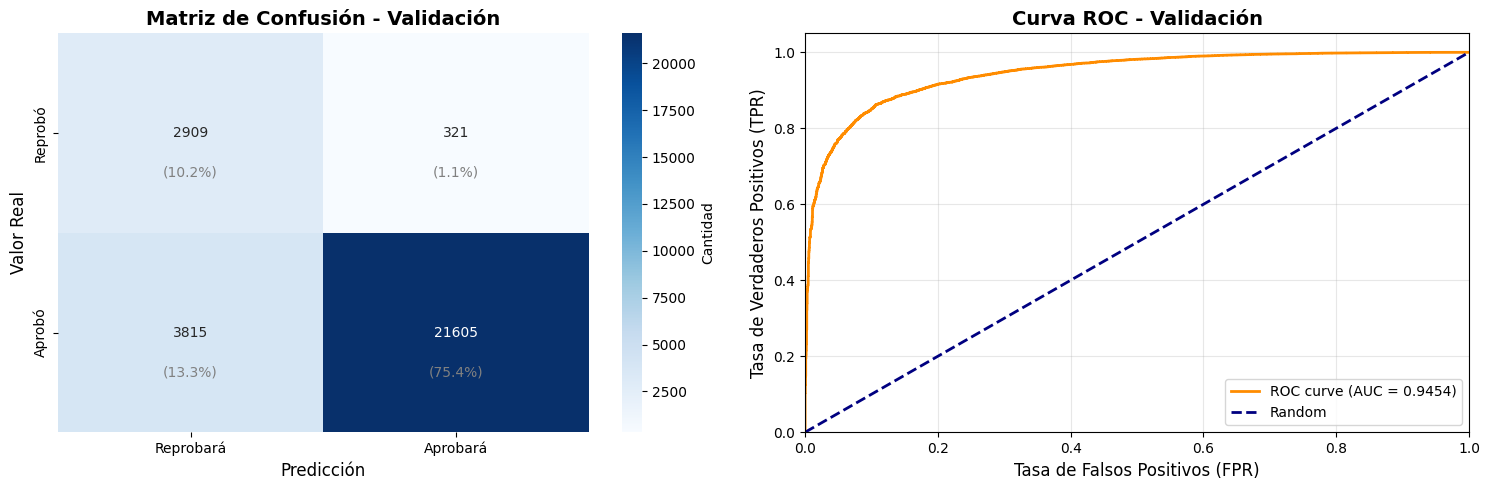


✅ EVALUACIÓN COMPLETADA



In [57]:
resultados_val = evaluar_modelo_completo(
    modelo=lr_model,
    X=X_test,
    y=y_test,
    nombre_conjunto='Validación',
    mostrar_graficos=True,
    guardar_graficos=True,
    ruta_guardado='models/lr_model_'
)

#### XGBOOST

In [58]:
# 4. XGBoost
print(f"\n{'#'*80}")
print(f"# MODELO 4: XGBOOST")
print(f"{'#'*80}")

# Calcular scale_pos_weight para balancear clases
scale_pos_weight = (y_train == 1).sum() / (y_train == 0).sum()

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss'
)
xgb_model = entrenar_evaluar_modelo('XGBoost', xgb_model, X_train, y_train, X_val, y_val, X_test, y_test)
joblib.dump(xgb_model, 'models/xgboost_model.pkl')
print(f"\n💾 Modelo guardado en 'models/xgboost_model.pkl'")


################################################################################
# MODELO 4: XGBOOST
################################################################################

🤖 Entrenando XGBoost...

📊 MÉTRICAS EN TRAIN (80% de 2020-2024):
  Accuracy: 0.9121
  ROC-AUC: 0.9592

📊 MÉTRICAS EN VALIDACIÓN (20% de 2020-2024):
  Accuracy: 0.9106
  ROC-AUC: 0.9504

  Classification Report:
              precision    recall  f1-score   support

   Reprobado       0.95      0.29      0.44      7433
    Aprobado       0.91      1.00      0.95     53309

    accuracy                           0.91     60742
   macro avg       0.93      0.64      0.70     60742
weighted avg       0.91      0.91      0.89     60742


📊 MÉTRICAS EN TEST (2025-1S):
  Accuracy: 0.9138
  ROC-AUC: 0.9514

  Classification Report:
              precision    recall  f1-score   support

   Reprobado       0.94      0.25      0.40      3230
    Aprobado       0.91      1.00      0.95     25420

    accuracy        


📊 EVALUACIÓN DEL MODELO EN VALIDACIÓN

📈 MÉTRICAS GENERALES:
  • Accuracy (Exactitud):     0.9138 (91.38%)
  • Precision (Precisión):    0.9129 (91.29%)
  • Recall (Sensibilidad):    0.9981 (99.81%)
  • F1-Score:                 0.9536
  • ROC-AUC:                  0.9514

📊 MATRIZ DE CONFUSIÓN:
  ┌─────────────────────────────────────┐
  │           Predicción                │
  │         Reprobará  │  Aprobará      │
  ├─────────────────────────────────────┤
  │ Real    │         │                 │
  │ Reprobó │     809   │     2421        │  TN / FP
  │ Aprobó  │      49   │    25371        │  FN / TP
  └─────────────────────────────────────┘

📋 INTERPRETACIÓN:
  • Verdaderos Negativos (TN): 809 - Correctamente predichos como REPROBARÁ
  • Falsos Positivos (FP):     2,421 - Incorrectamente predichos como APROBARÁ
  • Falsos Negativos (FN):     49 - Incorrectamente predichos como REPROBARÁ
  • Verdaderos Positivos (TP): 25,371 - Correctamente predichos como APROBARÁ

📊 DISTRIBUCIÓN

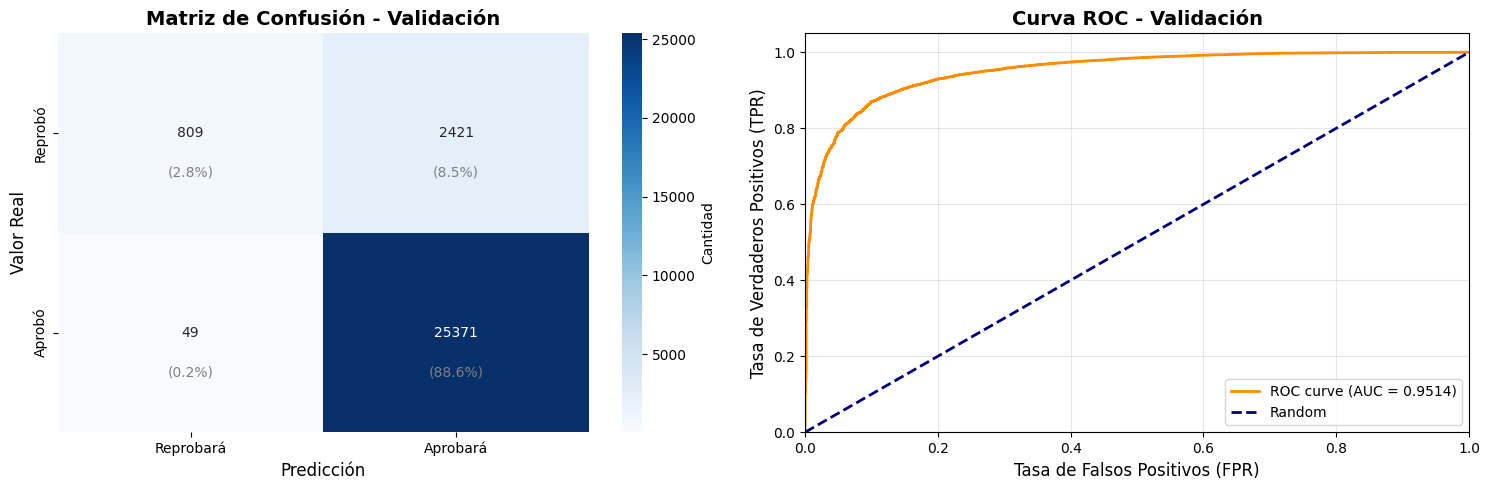


✅ EVALUACIÓN COMPLETADA



In [59]:
resultados_val = evaluar_modelo_completo(
    modelo=xgb_model,
    X=X_test,
    y=y_test,
    nombre_conjunto='Validación',
    mostrar_graficos=True,
    guardar_graficos=True,
    ruta_guardado='models/xgb_model_'
)

#### LGBMClassifier

In [60]:
# 4. LGBmodel
print(f"\n{'#'*80}")
print(f"# MODELO 4: LGBmodel")
print(f"{'#'*80}")

# Calcular scale_pos_weight para balancear clases
scale_pos_weight = (y_train == 1).sum() / (y_train == 0).sum()

lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight='balanced',
    force_row_wise=True
)
lgb_model = entrenar_evaluar_modelo('LGBmodel', lgb_model, X_train, y_train, X_val, y_val, X_test, y_test)
joblib.dump(lgb_model, 'models/lgb_model.pkl')
print(f"\n💾 Modelo guardado en 'models/xgboost_model.pkl'")


################################################################################
# MODELO 4: LGBmodel
################################################################################

🤖 Entrenando LGBmodel...
[LightGBM] [Info] Number of positive: 213236, number of negative: 29731
[LightGBM] [Info] Total Bins 3478
[LightGBM] [Info] Number of data points in the train set: 242967, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

📊 MÉTRICAS EN TRAIN (80% de 2020-2024):
  Accuracy: 0.8772
  ROC-AUC: 0.9590

📊 MÉTRICAS EN VALIDACIÓN (20% de 2020-2024):
  Accuracy: 0.8722
  ROC-AUC: 0.9509

  Classification Report:
              precision    recall  f1-score   support

   Reprobado       0.49      0.88      0.63      7433
    Aprobado       0.98      0.87      0.92     53309

    accuracy                           0.87     60742
   macro avg       0.73      0.88      0.78     607


📊 EVALUACIÓN DEL MODELO EN VALIDACIÓN

📈 MÉTRICAS GENERALES:
  • Accuracy (Exactitud):     0.8618 (86.18%)
  • Precision (Precisión):    0.9871 (98.71%)
  • Recall (Sensibilidad):    0.8554 (85.54%)
  • F1-Score:                 0.9166
  • ROC-AUC:                  0.9520

📊 MATRIZ DE CONFUSIÓN:
  ┌─────────────────────────────────────┐
  │           Predicción                │
  │         Reprobará  │  Aprobará      │
  ├─────────────────────────────────────┤
  │ Real    │         │                 │
  │ Reprobó │    2946   │      284        │  TN / FP
  │ Aprobó  │    3675   │    21745        │  FN / TP
  └─────────────────────────────────────┘

📋 INTERPRETACIÓN:
  • Verdaderos Negativos (TN): 2,946 - Correctamente predichos como REPROBARÁ
  • Falsos Positivos (FP):     284 - Incorrectamente predichos como APROBARÁ
  • Falsos Negativos (FN):     3,675 - Incorrectamente predichos como REPROBARÁ
  • Verdaderos Positivos (TP): 21,745 - Correctamente predichos como APROBARÁ

📊 DISTRIBUC

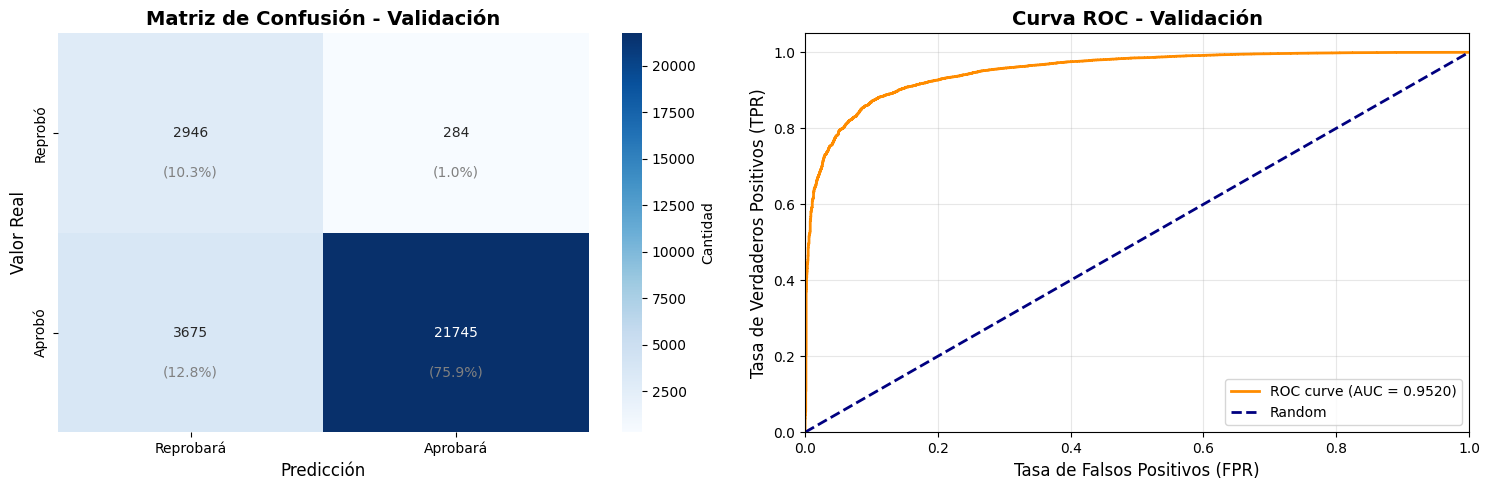


✅ EVALUACIÓN COMPLETADA



In [61]:
resultados_val = evaluar_modelo_completo(
    modelo=lgb_model,
    X=X_test,
    y=y_test,
    nombre_conjunto='Validación',
    mostrar_graficos=True,
    guardar_graficos=True,
    ruta_guardado='models/lgb_model_'
)

### Final

In [62]:
# Resumen final
print(f"\n{'='*80}")
print(f"✅ ENTRENAMIENTO COMPLETADO")
print(f"{'='*80}")
print(f"\n📁 Archivos guardados en la carpeta 'models/':")
print(f"  ✓ label_encoders.pkl - Encoders para variables categóricas")
print(f"  ✓ feature_info.pkl - Información de features")
print(f"  ✓ random_forest_model.pkl - Modelo Random Forest")
print(f"  ✓ svm_model.pkl - Modelo SVM")
print(f"  ✓ logistic_regression_model.pkl - Modelo Regresión Logística")
print(f"  ✓ xgboost_model.pkl - Modelo XGBoost")
if len(df_inferencia) > 0:
    print(f"  ✓ datos_inferencia_2025_2S.csv - Datos para inferencia futura")

print(f"\n📊 RESUMEN DE DATOS:")
print(f"  • Train: 2020-2024 (80%) - {len(X_train)} registros")
print(f"  • Val: 2020-2024 (20%) - {len(X_val)} registros")
if X_test is not None:
    print(f"  • Test: 2025-1S - {len(X_test)} registros")
if len(df_inferencia) > 0:
    print(f"  • Inferencia: 2025-2S - {len(df_inferencia)} registros (guardados para uso futuro)")

print(f"\n🎯 Variable objetivo: APROBO (1=Reprobado/PF, 0=Aprobado)")
print(f"📊 Total de features: {len(X_columns)}")
print(f"   - Numéricas: {len(features_numericas)}")
print(f"   - Categóricas (encoded): {len(features_encoded)}")


✅ ENTRENAMIENTO COMPLETADO

📁 Archivos guardados en la carpeta 'models/':
  ✓ label_encoders.pkl - Encoders para variables categóricas
  ✓ feature_info.pkl - Información de features
  ✓ random_forest_model.pkl - Modelo Random Forest
  ✓ svm_model.pkl - Modelo SVM
  ✓ logistic_regression_model.pkl - Modelo Regresión Logística
  ✓ xgboost_model.pkl - Modelo XGBoost
  ✓ datos_inferencia_2025_2S.csv - Datos para inferencia futura

📊 RESUMEN DE DATOS:
  • Train: 2020-2024 (80%) - 242967 registros
  • Val: 2020-2024 (20%) - 60742 registros
  • Test: 2025-1S - 28650 registros
  • Inferencia: 2025-2S - 30324 registros (guardados para uso futuro)

🎯 Variable objetivo: APROBO (1=Reprobado/PF, 0=Aprobado)
📊 Total de features: 45
   - Numéricas: 26
   - Categóricas (encoded): 19
